### Notebook for recapture.csv

#### 0. Read data, make some plots

,day,length_diff
,<dbl>,<int>
1,1.015926,4
2,0.945093,4
3,1.040220,5
4,2.057558,7
5,1.929063,9
6,1.565480,5


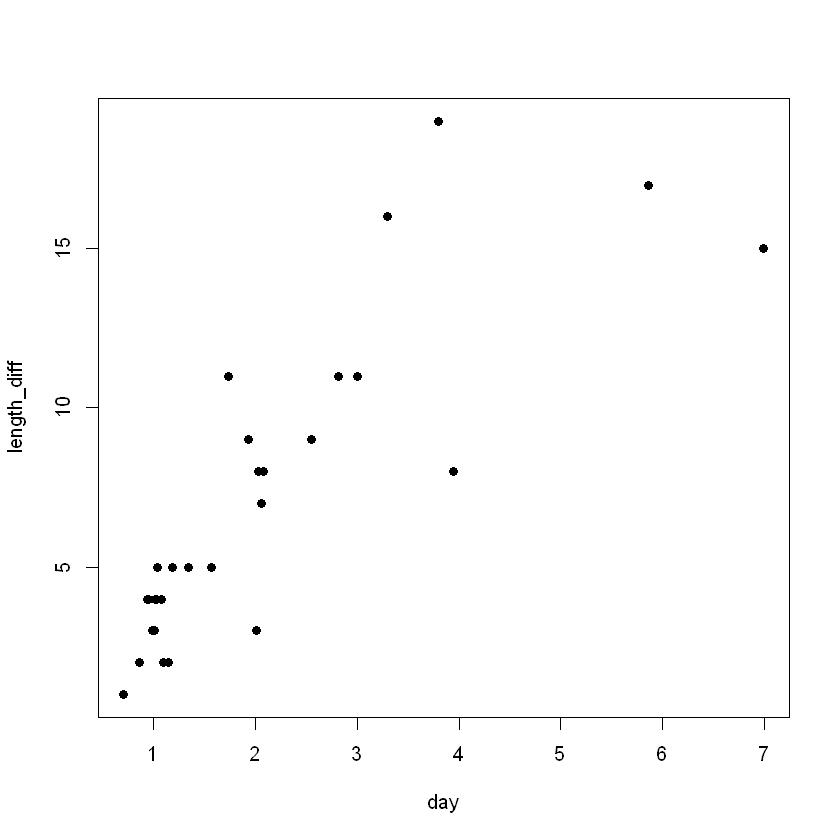

In [1]:
# READ DATA
recapture.data<-read.csv('recapture.csv', header=T)
head(recapture.data)
# SCATTER PLOT
plot(recapture.data, pch=16)

#### 1. Log-likelihood function and maximisation
I chose to model the error terms. Note that $\epsilon_i$ are i.i.d. $N(0, \sigma^2)$. <code>optim()</code> will find the best set of parameters such that those errors (distance between the observations and the fitted line) are as "normal" as possible, with mean 0 and a common variance. 

In [2]:
# THE LOG-LIKELIHOOD FOR THE LINEAR REGRESSION
# PARAMETERS HAVE TO BE INPUT AS A VECTOR
regression.log.likelihood<-function(parm, dat)
{
# DEFINE THE PARAMETERS parm
# WE HAVE THREE PARAMETERS: a, b, sigma. BE CAREFUL OF THE ORDER
a<-parm[1]
b<-parm[2]
sigma<-parm[3]

# DEFINE THE DATA dat
# FIRST COLUMN IS x, SECOND COLUMN IS y
x<-dat[,1]
y<-dat[,2]

# MODEL ON THE ERROR TERMS. VECTORISED
error.term<-(y-a-b*x)
# error.term[i] ARE IID NORMAL, WITH MEAN 0 AND A COMMON VARIANCE sigma^2
density<-dnorm(error.term, mean=0, sd=sigma, log=T)

# THE LOG-LIKELIHOOD IS THE SUM OF INDIVIDUAL LOG-DENSITY
return(sum(density))
}

In [3]:
# MAXIMISE
M2<-optim(par=c(1, 1, 1), regression.log.likelihood, dat=recapture.data, 
      method='L-BFGS-B', 
      lower=c(-1000, -1000, 0.001), upper=c(1000, 1000, 1000), 
      control=list(fnscale=-1))
M2

$par
[1] 1.527870 2.676240 2.678428

$value
[1] -69.72089

$counts
function gradient 
      40       40 

$convergence
[1] 0

$message
[1] "CONVERGENCE: REL_REDUCTION_OF_F <= FACTR*EPSMCH"

#### 2. log-likelihood function without the intercept, and LRT
Without the intercept the parameter space becomes 2D. 

In [4]:
regression.no.intercept.log.likelihood<-function(parm, dat)
{
# DEFINE THE PARAMETERS parm
# WE HAVE THREE PARAMETERS: a, b, sigma. BE CAREFUL OF THE ORDER
b<-parm[1]
sigma<-parm[2]

# DEFINE THE DATA dat
# FIRST COLUMN IS x, SECOND COLUMN IS y
x<-dat[,1]
y<-dat[,2]

# MODEL ON THE ERROR TERMS. VECTORISED
error.term<-(y-b*x)
# error.term[i] ARE IID NORMAL, WITH MEAN 0 AND A COMMON VARIANCE sigma^2
density<-dnorm(error.term, mean=0, sd=sigma, log=T)

# THE LOG-LIKELIHOOD IS THE SUM OF INDIVIDUAL LOG-DENSITY
return(sum(density))
}

In [5]:
M1<-optim(par=c(1,1), regression.no.intercept.log.likelihood, method='L-BFGS-B', 
          lower=c(-1000, 0.001), upper=c(1000, 1000), dat=recapture.data, 
         control=list(fnscale=-1))
M1

$par
[1] 3.162870 2.822933

$value
[1] -71.24473

$counts
function gradient 
      37       37 

$convergence
[1] 0

$message
[1] "CONVERGENCE: REL_REDUCTION_OF_F <= FACTR*EPSMCH"

In [6]:
# LRT, USING THE MAXIMISED LOG-LIKELIHOOD VALUES FROM BOTH MODELS
D<-2*(M2$value-M1$value)
D
# CRITICAL VALUE, CHI-SQUARE WITH DF=1
qchisq(0.95, df=1)

[1] 3.047676

[1] 3.841459

We accept M1 (no intercept) as the simplified model. Or we say the intercept is not significnatly different from 0. 

#### 3. log-likelihood surface, C.I. for a single parameter
We evaluate the log-likelihood exhaustively near the mle. 

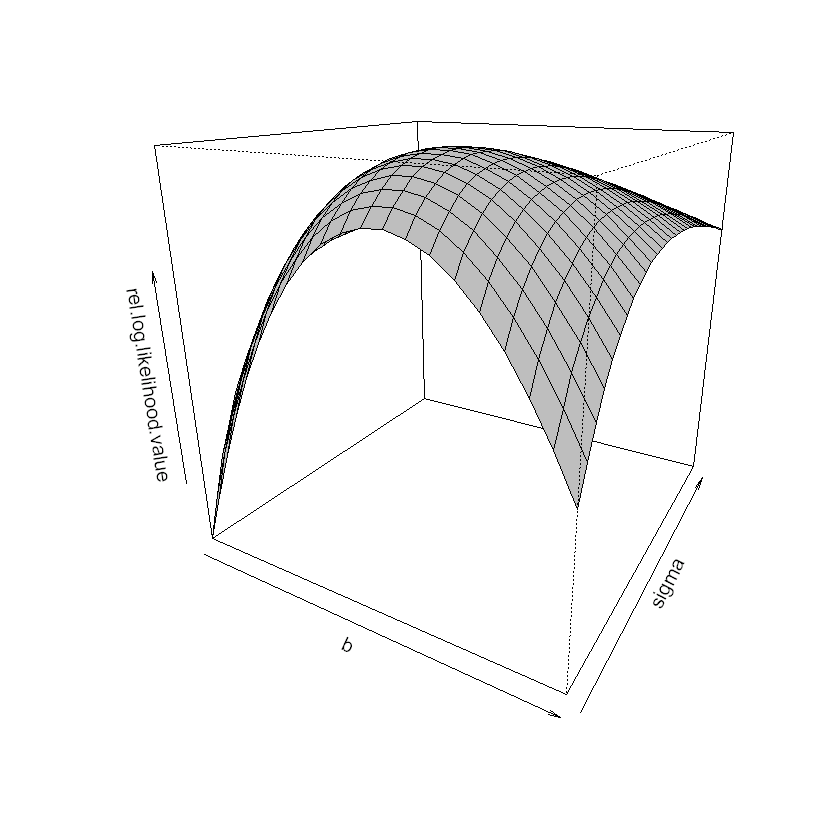

In [7]:
# DEFINE THE RANGE OF PARAMETERS VALUES
b<-seq(2, 4, 0.1)
sigma<-seq(2, 5, 0.1)

# THE LOG-LIKELIHOOD VALUE IS STORED IN A MATRIX
log.likelihood.value<-matrix(nr=length(b), nc=length(sigma))

# COMPUTE THE LOG-LIKELIHOOD VALUE FOR EACH PAIR OF VALUES. TWO PARAMETERS, TWO FOR LOOPS. 
for (i in 1:length(b))
  { 
   for (j in 1:length(sigma))
    {
    log.likelihood.value[i,j]<-
    regression.no.intercept.log.likelihood(parm=c(b[i],sigma[j]),
    dat=recapture.data)
    }
  }
# WE ARE INTERESTED IN KNOWING THE RELATIVE LOG-LIKELIHOOD VALUE 
# RELATIVE TO THE PEAK (MAXIMUM)
rel.log.likelihood.value<-log.likelihood.value-M1$value

# FUNCTION FOR 3D PLOT
persp(b, sigma, rel.log.likelihood.value, theta=30, phi=20, 
	xlab='b', ylab='sigma', zlab='rel.log.likelihood.value', 
	col='grey')


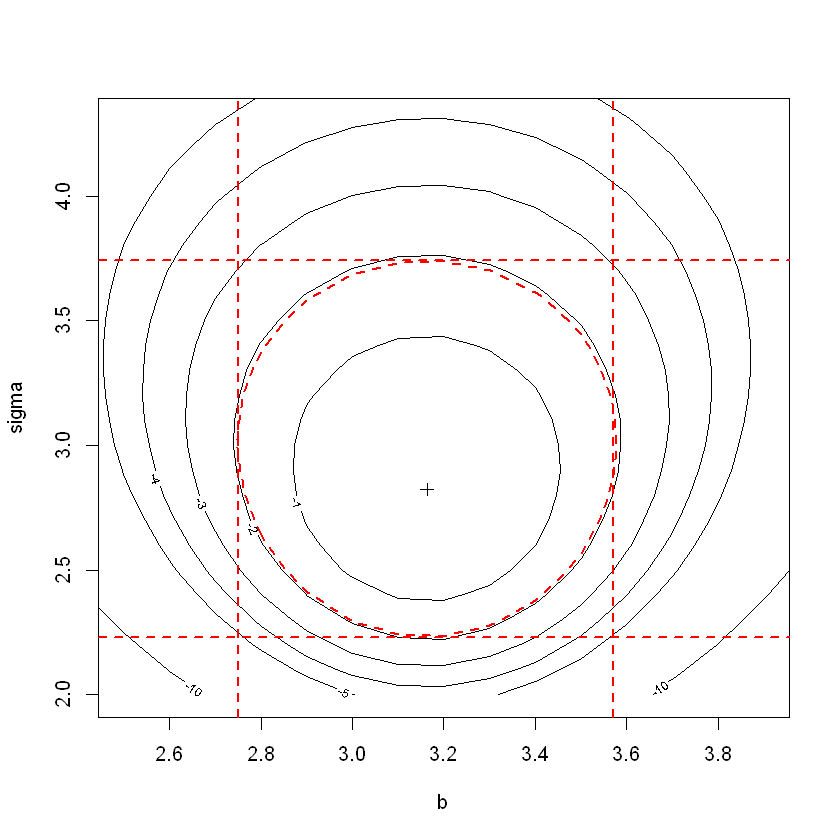

In [8]:
# CONTOUR PLOT
contour(b, sigma, rel.log.likelihood.value, xlab='b', ylab='sigma', 
	xlim=c(2.5, 3.9), ylim=c(2.0, 4.3), 
	levels=c(-1:-5, -10), cex=2)
# DRAW A CROSS TO INDICATE THE MAXIMUM
points(M1$par[1], M1$par[2], pch=3)
# ADD -1.92 CONTOUR LINE
contour.line<-contourLines(b, sigma, rel.log.likelihood.value, 	levels=-1.92)[[1]]
lines(contour.line$x, contour.line$y, col='red', 
	lty=2, lwd=2)
abline(v=c(2.75, 3.57), lty=2, col='red', lwd=2)
abline(h=c(2.23, 3.74), lty=2, col='red', lwd=2)

With the -1.92 contour line we can find the inidividual C.I. for $b$ and $\sigma$ by looking at the widest part of the -1.92 circle in both dimension. Here the 95% C.I. for $b$ is [2.75, 3.57], and the 95% C.I. for $\sigma$ is [2.23, 3.74]. 

#### 4. Joint C.I. 
To find joint C.I. (also called the joint confidence *region*) for the two parameters we need to another contour line which is <code>0.5*qchisq(0.95, df=2)</code> from the maximum: 

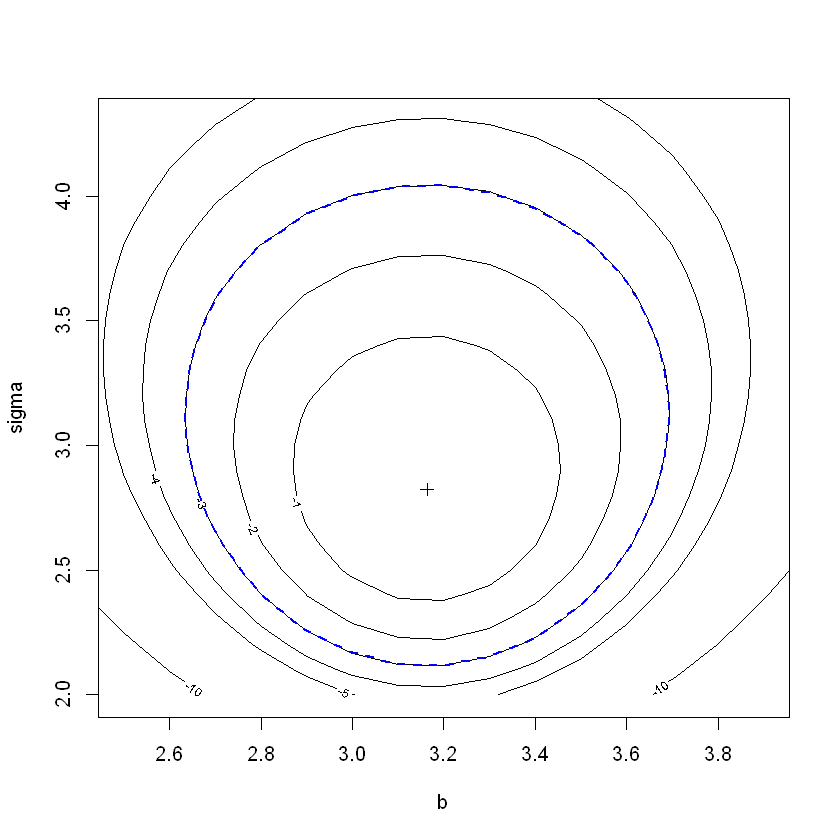

In [9]:
# CONTOUR PLOT
contour(b, sigma, rel.log.likelihood.value, xlab='b', ylab='sigma', 
	xlim=c(2.5, 3.9), ylim=c(2.0, 4.3), 
	levels=c(-1:-5, -10), cex=2)
# DRAW A CROSS TO INDICATE THE MAXIMUM
points(M1$par[1], M1$par[2], pch=3)
# ADD -2.99 CONTOUR LINE
contour.line<-contourLines(b, sigma, rel.log.likelihood.value, 	levels=-0.5*qchisq(0.95, df=2))[[1]]
lines(contour.line$x, contour.line$y, col='blue', 
	lty=2, lwd=2)

The 95% joint confidence region are all the points within this circle. 

#### 5. Wald C.I. and Hessian matrix
Hessian matrix is the second derivative of the log-liklihood evaluated at the peak. The variance-covariance structure of the two mle is the negative inverse of the Hessian matrix. Note that all variance-covariance matrices are symmetric and positive definite (analogy to the univariate case that variances are positive. But in the language of matrix "positive" means "positive definite"). 

In [10]:
M1<-optim(par=c(1,1), regression.no.intercept.log.likelihood, method='L-BFGS-B', 
          lower=c(-1000, 0.001), upper=c(1000, 1000), dat=recapture.data, 
         control=list(fnscale=-1), hessian=T)
M1$hessian

-2.365676e+01,4.369838e-06
4.369838e-06,-7.278256e+00


In [11]:
vcov<-(-1)*solve(M1$hessian)
vcov

4.227122e-02,2.537948e-08
2.537948e-08,1.373956e-01


The 95% C.I. for $b$ under approximate normality is:

In [12]:
# LOWER 95% C.I. FOR b
M1$par[1]-1.96*sqrt(vcov[1,1])
# UPPER C.I.
M1$par[1]+1.96*sqrt(vcov[1,1])

[1] 2.759894

[1] 3.565845